In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go
# import plotly.express as px
from scipy.integrate import solve_ivp 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits import mplot3d
import string
import networkx as nx

In [2]:
# Number of individuals in the community
N = 10000

# Number of communities and edges added per epoch
M = 100

# Start and End epochs
t0, tf = 0, 3000

# Number of timesteps
Nt = 3000

# Time series
t = np.linspace(t0, tf, Nt + 1)

# Differential equation params
sigma = 0.1
a0 = 0.01
a1 = 0.0001
gamma = 0.07
zeta = 0.02
chi = 0.1

# Setup for the beta slider
beta_min = 0
beta_max = 0.06

beta_steps = 100

# Coupling strength steps
epsilon_steps = M

# Patch steps
l_steps = M - 1

# l-values for simulation
p = 0.2
l1 = int(p * M)
l2 = int((1. - p) * M)

# The randomisation for exposed population will be upto max_exposed
max_exposed = 1000

# Generating all the lists
epsilon_list = np.logspace(-5, 1, epsilon_steps, base=10)
l_list = np.arange(1, M)
beta_list = np.linspace(beta_min, beta_max, beta_steps)
custom_E0 = np.random.randint(1, max_exposed, size=(M,1))

In [3]:
# Making a complete graph with 4 Nodes
# adj_mat = np.full((M, M), 1, dtype="int").reshape(M, M)
graph = nx.erdos_renyi_graph(M, 0.3, seed=None, directed=False)
adj_mat = nx.to_numpy_array(graph).reshape(M, M)

# Making the degree list for each node (di = M-1 here)
degree_list = np.sum(adj_mat, axis=0).reshape(M, 1)

# Dividing the adjacency matrix by rowsum
row_sums= np.sum(adj_mat, axis=1)
adj_mat_normalised = (adj_mat/row_sums[:,np.newaxis]).reshape(M, M)

In [4]:
def get_degree_counts(n : int, adj_mat):
    freq_map = np.zeros(n) # degree -> count
    for i in range(n):
        num_neighbours = int(np.sum(adj_mat[i]))
        freq_map[num_neighbours] += 1
    return np.array(freq_map)

In [5]:
# Returns a uniform probability distribution
def const_prob(adj_mat, patches_to_apply):
    m = int(len(adj_mat)) # Number of communities

    # each node as probability as 1/patches_to_apply
    retval = np.full(m, 1, dtype="float") / float(patches_to_apply)

    # Replace with zero in the range [patches_to_apply, len(adj_list))
    np.put(retval, np.arange(patches_to_apply, M), 0)

    return retval

In [6]:
# Returns node wise distribution strategy for test kits
def g_val(a1, K, prob_distri_test_kit):
    return a1 * K * prob_distri_test_kit

In [7]:
def migration_term(adj_mat, adj_mat_normalised, compartment):
    # Getting the Amn x Sm term
    retval = np.dot(adj_mat_normalised, compartment).reshape(int(len(compartment)), 1)
    
    # Returning the migration amount
    return (retval - compartment)

In [8]:
def ODE_multi_node_with_testkit(t, X_flat, beta, adj_mat, adj_mat_normalised, degree_list, shape_X, epsilon, num_patches, l, gamma, sigma, zeta, chi, a0, a1):
    # Unraveling the X_flat vector
    X = X_flat.reshape(shape_X) 
    S, E, I, H, R, K = X
    
    # Reshaping into patchesx1 matrix from rank-1 array
    S = S.reshape(num_patches, 1)
    E = E.reshape(num_patches, 1)
    I = I.reshape(num_patches, 1)
    H = H.reshape(num_patches, 1)
    R = R.reshape(num_patches, 1)
    
    # Warning : K is a number NOT a list
    # So, we will turn it into a "fake" list by repeating it num_patches times
    K = K.reshape(num_patches, 1)
    
    # We are using degree centrality based test kit distribution
    g = g_val(a1, K[0], const_prob(adj_mat, l).reshape(num_patches, 1))

    # Reshaping into num_patches x 1 matrix
    g = g.reshape(num_patches, 1)
    
    # Obtaining the total population of each patch
    tot_pop = S + E + I + H + R
    
    # Hospitalization param
    alpha = a0 + g
    
    S_migration = ((epsilon) * migration_term(adj_mat, adj_mat_normalised, S)).reshape(num_patches, 1)
    E_migration = ((epsilon) * migration_term(adj_mat, adj_mat_normalised, E)).reshape(num_patches, 1)
    I_migration = ((epsilon) * migration_term(adj_mat, adj_mat_normalised, I)).reshape(num_patches, 1)
    R_migration = ((epsilon) * migration_term(adj_mat, adj_mat_normalised, R)).reshape(num_patches, 1)
    
    # Find the derivatives list, broadcasting coming in clutch now
    dSdt = (np.divide(-(beta * S * I), tot_pop)) +  S_migration
    dEdt = (np.divide((beta * S * I), tot_pop)) - (sigma * E) + E_migration
    dIdt = (sigma * E) -  (alpha * I) + I_migration
    dHdt = (alpha * I) - (gamma * H)
    dRdt = (gamma * H) + R_migration
    dKdt = (zeta * np.full(num_patches, np.sum(I)).reshape(num_patches, 1)) - (chi * K)
    
    # Reshape the derivatives list for good measure
    dSdt = dSdt.reshape(num_patches, 1)
    dEdt = dEdt.reshape(num_patches, 1)
    dIdt = dIdt.reshape(num_patches, 1)
    dHdt = dHdt.reshape(num_patches, 1)
    dRdt = dRdt.reshape(num_patches, 1)
    dKdt = dKdt.reshape(num_patches, 1)
        
    derivs =  np.array([dSdt, dEdt, dIdt, dHdt, dRdt, dKdt])
    
    return derivs.ravel()

def ODE_multi_node_without_testkit(t, X_flat, beta, adj_mat, adj_mat_normalised, degree_list, shape_X, epsilon, num_patches, l, gamma, sigma, zeta, chi, a0, a1):
    return ODE_multi_node_with_testkit(t, X_flat, beta, adj_mat, adj_mat_normalised, degree_list, shape_X, epsilon, num_patches, l, gamma, sigma, zeta, chi, a0, 0)

In [9]:
def solver(adj_mat, adj_mat_normalised, degree_list, M, beta, ODE_func, E0, epsilon, num_patches, l):
    # Initial conditions for given beta
    I0, H0, R0, K0 = np.zeros(M), np.zeros(M), np.zeros(M), np.zeros(M)

    # Mandatory reshaping, for safety
    E0 = E0.reshape(M, 1)
    I0 = I0.reshape(M, 1)
    H0 = H0.reshape(M, 1)
    R0 = R0.reshape(M, 1)
    K0 = K0.reshape(M, 1)
    
    # Getting the susceptibles
    # [TBX : This makes N*M susceptibles by broadcasting]
    Total_population = np.full(M, N).reshape(M, 1)
    S0 = Total_population - E0 - I0 - H0 - R0
    S0 = S0.reshape(M, 1)

    # Making the state vector
    X0 = np.array([S0, E0, I0, H0, R0, K0])

    # Ravel the X vector temporarily
    shape_X = X0.shape
    X_flat = X0.ravel()

    # Solving the initial value problem
    solved_ivp = solve_ivp(ODE_func, (t0, tf), X_flat, args=(beta, adj_mat, adj_mat_normalised, degree_list, shape_X, epsilon, num_patches, l, gamma, sigma, zeta, chi, a0, a1), t_eval=t)

    # Returning the raw solved ivp data for plotting
    # solved_ivp.y.reshape(6, M, Nt+1)
    return solved_ivp

# Generating data for the $\mathcal{I}_{max}$ plots

In [10]:
# X and Y with testkits
x_with_testkits1 = np.array([])
y_with_testkits1 = np.array([])
y_with_testkits1_mean = np.array([])
y_with_testkits1_max = np.array([])
y_with_testkits1_min = np.array([])

# X and Y without testkits
x_without_testkits1 = np.array([])
y_without_testkits1 = np.array([])
y_without_testkits1_mean = np.array([])
y_without_testkits1_max = np.array([])
y_without_testkits1_min = np.array([])

for epsilon_value in epsilon_list:
    # Initial condition
    custom_E0 = np.random.randint(1, max_exposed, size=(M,1))

    # Solving the IVP using our solver function
    solved_ivp = solver(adj_mat, adj_mat_normalised, degree_list, M, 0.03, ODE_multi_node_with_testkit, custom_E0, epsilon_value, M, l1)

    # Obtaining the shape we need to realize the y values
    reshape_vals = (6, M, solved_ivp.y.shape[1])
    
    # Getting the y value reshaped
    jffy = solved_ivp.y.reshape(reshape_vals)[2]

    # Obtaining the Infection values for each communities
    I_vals = (solved_ivp.y.reshape(6, M, reshape_vals[2])[2]).reshape(M, reshape_vals[2])

    # Getting the I_max values from I_vals
    I_max = np.max(I_vals, axis=1).reshape(M, 1)
    
    # Colour list for testkit and testkit-free communities
    color_list = ["#F08080", "#80F080", "#8080F0"]
    
    # x1, y1 for the "with testkit nodes"
    x1 = np.full(M, epsilon_value)[:l1]
    y1 = I_max.T[0][:l1] / N
    marker_color_with_testkits = color_list[0]
    
    y_with_testkits1 = np.append(y_with_testkits1, y1)
    x_with_testkits1 = np.append(x_with_testkits1, x1)
    y_with_testkits1_mean = np.append(y_with_testkits1_mean, [np.sum(y1) / l1])
    y_with_testkits1_max = np.append(y_with_testkits1_max, [np.max(y1)])
    y_with_testkits1_min = np.append(y_with_testkits1_min, [np.min(y1)])
    
    # x2, y2 for the "without testkit nodes"
    x2 = np.full(M, epsilon_value)[l1:-1]
    y2 = I_max.T[0][l1:-1] / N
    marker_color_without_testkits = color_list[1]
    
    y_without_testkits1 = np.append(y_without_testkits1, y2)
    x_without_testkits1 = np.append(x_without_testkits1, x2)
    y_without_testkits1_mean = np.append(y_without_testkits1_mean, [np.sum(y2) / (y2.shape[0])])
    y_without_testkits1_max = np.append(y_without_testkits1_max, [np.max(y2)])
    y_without_testkits1_min = np.append(y_without_testkits1_min, [np.min(y2)])

    # Increment the current epsilon step number
    I_max_vs_epsilon_list = np.zeros(shape=(epsilon_steps, M))

In [11]:
# X and Y with testkits
x_with_testkits2 = np.array([])
y_with_testkits2 = np.array([])
y_with_testkits2_mean = np.array([])
y_with_testkits2_max = np.array([])
y_with_testkits2_min = np.array([])

# X and Y without testkits
x_without_testkits2 = np.array([])
y_without_testkits2 = np.array([])
y_without_testkits2_mean = np.array([])
y_without_testkits2_max = np.array([])
y_without_testkits2_min = np.array([])


for epsilon_value in epsilon_list:
    # Initial condition
    custom_E0 = np.random.randint(1, max_exposed, size=(M,1))

    # Solving the IVP using our solver function
    solved_ivp = solver(adj_mat, adj_mat_normalised, degree_list, M, 0.03, ODE_multi_node_with_testkit, custom_E0, epsilon_value, M, l2)

    # Obtaining the shape we need to realize the y values
    reshape_vals = (6, M, solved_ivp.y.shape[1])
    
    # Getting the y value reshaped
    jffy = solved_ivp.y.reshape(reshape_vals)[2]

    # Obtaining the Infection values for each communities
    I_vals = (solved_ivp.y.reshape(6, M, reshape_vals[2])[2]).reshape(M, reshape_vals[2])

    # Getting the I_max values from I_vals
    I_max = np.max(I_vals, axis=1).reshape(M, 1)
    
    # Colour list for testkit and testkit-free communities
    color_list = ["#F08080", "#80F080", "#8080F0"]
    
    # x1, y1 for the "with testkit nodes"
    x1 = np.full(M, epsilon_value)[:l2]
    y1 = I_max.T[0][:l2] / N
    marker_color_with_testkits = color_list[0]
    
    y_with_testkits2 = np.append(y_with_testkits2, y1)
    x_with_testkits2 = np.append(x_with_testkits2, x1)
    y_with_testkits2_mean = np.append(y_with_testkits2_mean, [np.sum(y1) / l2])
    y_with_testkits2_max = np.append(y_with_testkits2_max, [np.max(y1)])
    y_with_testkits2_min = np.append(y_with_testkits2_min, [np.min(y1)])
    
    # x2, y2 for the "without testkit nodes"
    x2 = np.full(M, epsilon_value)[l2:-1]
    y2 = I_max.T[0][l2:-1] / N
    marker_color_without_testkits = color_list[1]
    
    y_without_testkits2 = np.append(y_without_testkits2, y2)
    x_without_testkits2 = np.append(x_without_testkits2, x2)
    y_without_testkits2_mean = np.append(y_without_testkits2_mean, [np.sum(y2) / (y2.shape[0])])
    y_without_testkits2_max = np.append(y_without_testkits2_max, [np.max(y2)])
    y_without_testkits2_min = np.append(y_without_testkits2_min, [np.min(y2)])
    
    # Increment the current epsilon step number
    I_max_vs_epsilon_list = np.zeros(shape=(epsilon_steps, M))

# Generating data for the RMSE plots

In [12]:
RMSE_total1=[]
RMSE_test_kits1=[]
RMSE_wo_test_kits1=[]

for epsilon_value in epsilon_list:
    # Initial conditions
    custom_E0 = np.random.randint(1, max_exposed, size=(M,1))
    
    # Solving IVP 
    solved_ivp = solver(adj_mat, adj_mat_normalised, degree_list, M, 0.03, ODE_multi_node_with_testkit, custom_E0, epsilon_value, M, l1)
    
    # Getting the solved equations
    jffy = solved_ivp.y.reshape(6, M, Nt+1)
    
    #-----------Total Synchronisation Error---------------------------------------
    
    # The 3rd element is "I", this is a matrix of size M x Nt
    infection = jffy[2] / N
            
    # The mean of communities at each time (array of size Nt)
    infection_mean = np.mean(infection, axis = 0) # max around 200
    
    # Resize to set as array of size Nt + 1
    infection_mean.resize(1, Nt + 1)
        
    # Broadcast to get array-wise difference => xi - x_mean
    infection_diff = infection - infection_mean
        
    # Take element-wise square
    infection_diff_squares = np.square(infection_diff)

    
    # mean squared differences
    infection_mse = np.mean(infection_diff_squares, axis=0)
    infection_mse.resize(1, Nt + 1)
    
    # RMSE total
    infection_rmse = np.sqrt(infection_mse)
    
    # Time average
    infection_rmse_time_avg = np.mean(infection_rmse)

    # Add entry to the RMSE_total list
    RMSE_total1.append(infection_rmse_time_avg)
#---------------Cluster Synchronisation error------------------------------------------
    # with test kit nodes
    test_kit_nodes=infection[:l1]
#     print(test_kit_nodes.shape)
    rmse_test_kit= np.mean(
                        np.sqrt(
                            np.mean(
                                (test_kit_nodes-np.mean(test_kit_nodes,axis=0).reshape(1,Nt+1))**2,axis=0).reshape(1,Nt+1)))

    RMSE_test_kits1.append(rmse_test_kit) 

    # without test kit  
    non_test_kit_nodes=infection[l1:]
    rmse_wo_test_kits= np.mean(
                        np.sqrt(
                            np.mean(
                                (non_test_kit_nodes-np.mean(non_test_kit_nodes,axis=0).reshape(1,Nt+1))**2,axis=0).reshape(1,Nt+1)))

    RMSE_wo_test_kits1.append(rmse_wo_test_kits)

In [13]:
RMSE_total2=[]
RMSE_test_kits2=[]
RMSE_wo_test_kits2=[]

for epsilon_value in epsilon_list:
    # Initial conditions
    custom_E0 = np.random.randint(1, max_exposed, size=(M,1))
    
    # Solving IVP 
    solved_ivp = solver(adj_mat, adj_mat_normalised, degree_list, M, 0.03, ODE_multi_node_with_testkit, custom_E0, epsilon_value, M, l2)
    
    # Getting the solved equations
    jffy = solved_ivp.y.reshape(6, M, Nt+1)
    
    #-----------Total Synchronisation Error---------------------------------------
    
    # The 3rd element is "I", this is a matrix of size M x Nt
    infection = jffy[2] / N
            
    # The mean of communities at each time (array of size Nt)
    infection_mean = np.mean(infection, axis = 0) # max around 200
    
    # Resize to set as array of size Nt + 1
    infection_mean.resize(1, Nt + 1)
        
    # Broadcast to get array-wise difference => xi - x_mean
    infection_diff = infection - infection_mean
        
    # Take element-wise square
    infection_diff_squares = np.square(infection_diff)

    
    # mean squared differences
    infection_mse = np.mean(infection_diff_squares, axis=0)
    infection_mse.resize(1, Nt + 1)
    
    # RMSE total
    infection_rmse = np.sqrt(infection_mse)
    
    # Time average
    infection_rmse_time_avg = np.mean(infection_rmse)

    # Add entry to the RMSE_total list
    RMSE_total2.append(infection_rmse_time_avg)
#---------------Cluster Synchronisation error------------------------------------------
    # with test kit nodes
    test_kit_nodes=infection[:l2]
#     print(test_kit_nodes.shape)
    rmse_test_kit= np.mean(
                        np.sqrt(
                            np.mean(
                                (test_kit_nodes-np.mean(test_kit_nodes,axis=0).reshape(1,Nt+1))**2,axis=0).reshape(1,Nt+1)))

    RMSE_test_kits2.append(rmse_test_kit)

    # without test kit  
    non_test_kit_nodes=infection[l2:]
    rmse_wo_test_kits= np.mean(
                        np.sqrt(
                            np.mean(
                                (non_test_kit_nodes-np.mean(non_test_kit_nodes,axis=0).reshape(1,Nt+1))**2,axis=0).reshape(1,Nt+1)))

    RMSE_wo_test_kits2.append(rmse_wo_test_kits)

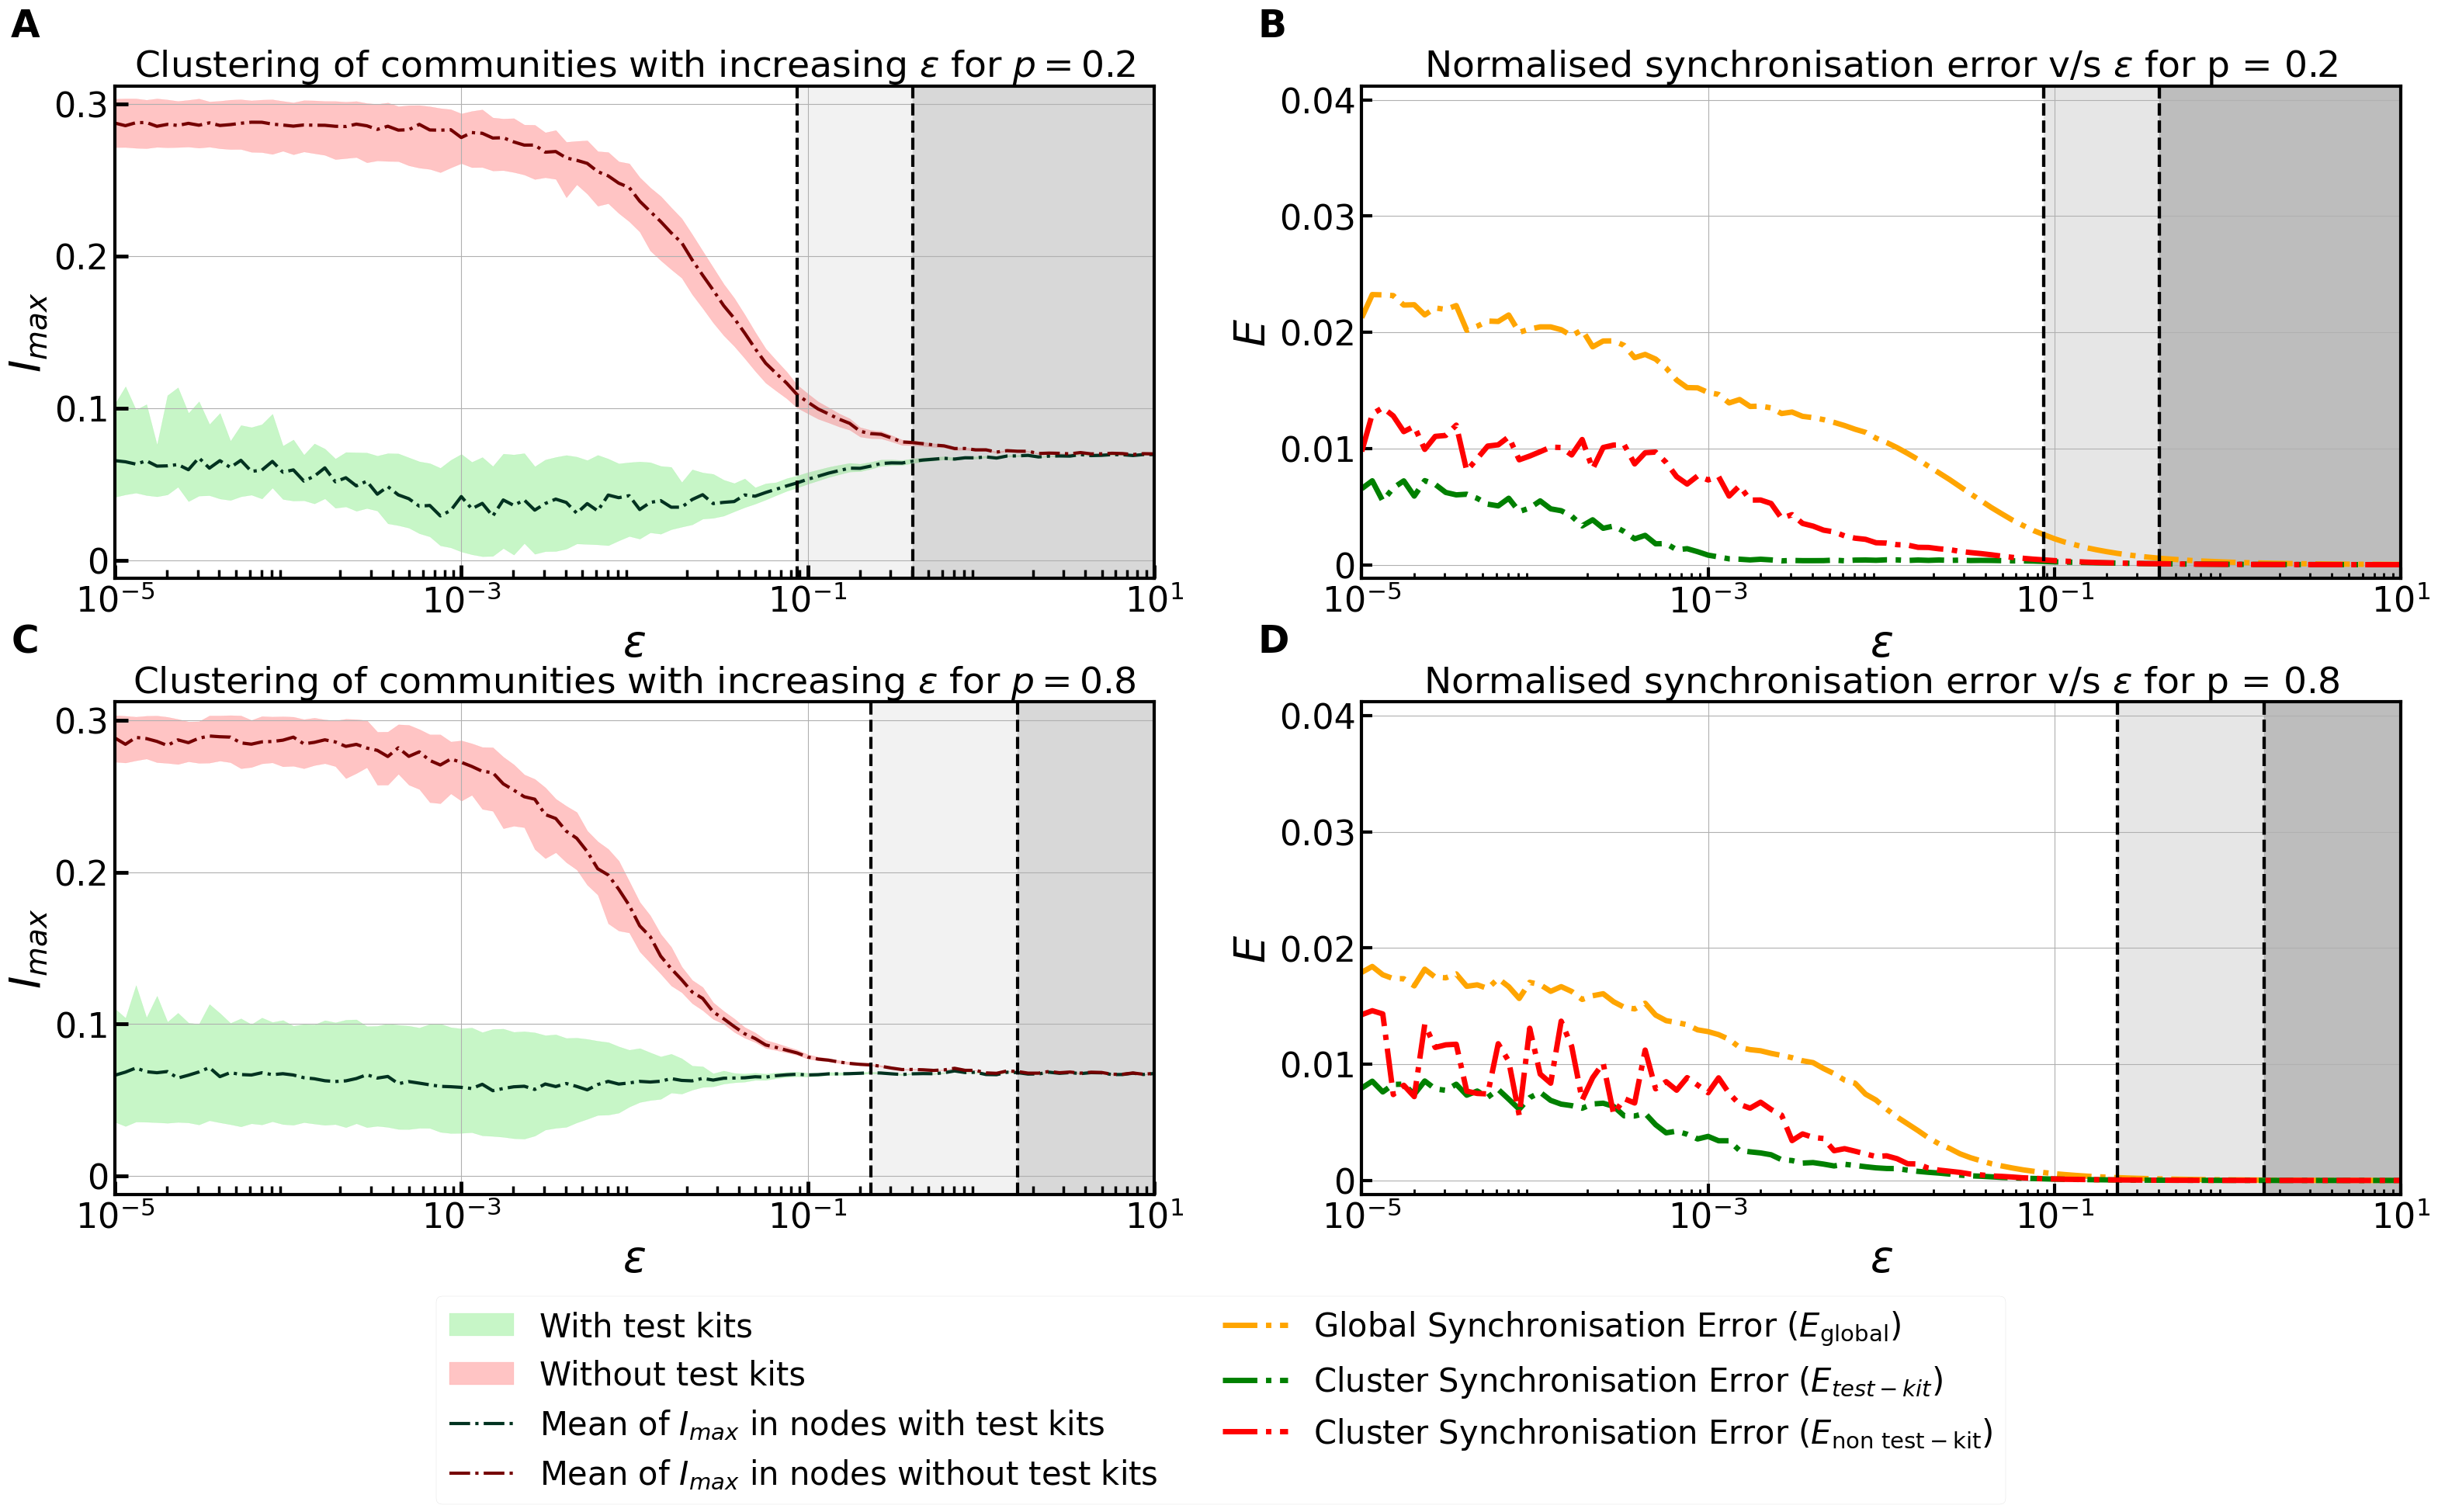

In [14]:
with plt.style.context('seaborn-paper'):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(38, 21))
    
    fs_label = 40
    fs_ticks = 32
    fs_title = 34
    
    ###############################################################
    axs[0][0].fill_between(epsilon_list, y_with_testkits1_min, y_with_testkits1_max, color='#90ee90', label='With test kits', alpha=0.5)
    axs[0][0].fill_between(epsilon_list, y_without_testkits1_min, y_without_testkits1_max, color='#ff8a8a', label='Without test kits', alpha=0.5)

    axs[0][0].plot(epsilon_list, y_with_testkits1_mean, c='#013220', label='Mean of $I_{max}$ in nodes with test kits', linestyle = '-.', linewidth=3)
    axs[0][0].plot(epsilon_list, y_without_testkits1_mean, c='#750000', label='Mean of $I_{max}$ in nodes without test kits', linestyle = '-.', linewidth=3)

    axs[0][0].set_xlabel("$\epsilon$", fontsize=fs_label)
    axs[0][0].set_ylabel("$I_{max}$", fontsize=fs_label)
    
    axs[0][0].set_xscale('log')
    
    axs[0][0].set_title(f"Clustering of communities with increasing $\epsilon$ for $p = {p}$", fontsize=fs_title)
    
    axs[0][0].grid()
    
    ###############################################################
    axs[1][0].fill_between(epsilon_list, y_with_testkits2_min, y_with_testkits2_max, color='#90ee90', label='With test kits', alpha=0.5)
    axs[1][0].fill_between(epsilon_list, y_without_testkits2_min, y_without_testkits2_max, color='#ff8a8a', label='Without test kits', alpha=0.5)

    axs[1][0].plot(epsilon_list, y_with_testkits2_mean, c='#013220', label='Mean of $I_{max}$ in nodes with test kits', linestyle = '-.', linewidth=3)
    axs[1][0].plot(epsilon_list, y_without_testkits2_mean, c='#750000', label='Mean of $I_{max}$ in nodes without test kits', linestyle = '-.', linewidth=3)

    axs[1][0].set_xlabel("$\epsilon$", fontsize=fs_label)
    axs[1][0].set_ylabel("$I_{max}$", fontsize=fs_label)

    axs[1][0].set_xscale('log')
    
    axs[1][0].set_title(f"Clustering of communities with increasing $\epsilon$ for $p = {1. - p}$", fontsize=fs_title)
    
    axs[1][0].grid()
    
    ###############################################################
    y1 = RMSE_total1
    y2 = RMSE_test_kits1
    y3 = RMSE_wo_test_kits1
    
    ###############################################################
    axs[0][1].set_title(f"Normalised synchronisation error v/s $\epsilon$ for p = {p}", fontsize=fs_title)
    axs[0][1].plot(epsilon_list, y1, color = 'orange', linestyle = '-.', label='Global Synchronisation Error ($E_{\mathrm{global}}$)', linewidth=5)
    axs[0][1].plot(epsilon_list, y2, 'g-.', label='Cluster Synchronisation Error ($E_{test-kit}$)', linewidth=5)
    axs[0][1].plot(epsilon_list, y3, 'r-.', label='Cluster Synchronisation Error ($E_{\mathrm{non\ test-kit}}$)', linewidth=5)
    axs[0][1].grid()
    axs[0][1].set_xlabel("$\epsilon$", fontsize=fs_label)
    axs[0][1].set_ylabel("$E$", fontsize=fs_label)

    axs[0][1].set_xscale('log')

    ###############################################################
    y1 = RMSE_total2
    y2 = RMSE_test_kits2
    y3 = RMSE_wo_test_kits2
    
    ###############################################################
    axs[1][1].set_title(f"Normalised synchronisation error v/s $\epsilon$ for p = {1. - p}", fontsize=fs_title)
    axs[1][1].plot(epsilon_list, y1, color = 'orange', linestyle = '-.', label='Global Synchronisation Error ($E_{\mathrm{global}}$)', linewidth=5)
    axs[1][1].plot(epsilon_list, y2, 'g-.', label='Cluster Synchronisation Error ($E_{test-kit}$)', linewidth=5)
    axs[1][1].plot(epsilon_list, y3, 'r-.', label='Cluster Synchronisation Error ($E_{\mathrm{non\ test-kit}}$)', linewidth=5)
    axs[1][1].grid()
    axs[1][1].set_xlabel("$\epsilon$", fontsize=fs_label)
    axs[1][1].set_ylabel("$E$", fontsize=fs_label)


    axs[1][1].set_xscale('log')
    
    ##############################################################
    plt_idx = 0
    for i in range(2):
        for j in range(2):
            axs[i][j].text(
                        -0.1, 
                        1.1, 
                        string.ascii_uppercase[plt_idx], 
                        transform=axs[i][j].transAxes, 
                        size=35, 
                        weight='bold'
                        )
            
            if (j == 0):
                axs[i][j].tick_params(direction= 'in', which='major', length=12,width=3.5)
                axs[i][j].tick_params(direction= 'in', which='minor', length=8, width=2.5)
            else:
                axs[i][j].tick_params(direction='in', which='major', length=10, width=3)
                axs[i][j].tick_params(direction='in', which='minor', length=5, width=2) 
            
            for axis in ['top','bottom','left','right']:
                axs[i][j].spines[axis].set_linewidth(3)
                
            
            x_ticks_labels = [r'$10^{-5}$', r'$10^{-3}$', r'$10^{-1}$', r'$10^{1}$']
            x_ticks_vals = [10**(-5), 10**(-3), 10**(-1), 10**(1)]
            
            axs[i][j].set_xticks([float(x_tick) for x_tick in x_ticks_vals],
                             [str(x_tick) for x_tick in x_ticks_labels],
                                fontsize=fs_ticks)
            
            axs[i][j].set_xlim(epsilon_list[0], epsilon_list[-1])

            if (j == 0):
                y_ticks_imax = [0, 0.1, 0.2, 0.3]
                axs[i][j].set_yticks([float(y_tick) for y_tick in y_ticks_imax],
                                 [str(round(y_tick, 2)) for y_tick in y_ticks_imax],
                                fontsize=fs_ticks)
                axs[i][j].set_ylim(y_ticks_imax[0] - 0.012, y_ticks_imax[-1] + 0.012)
                
            else:
                y_ticks_rmse = [0, 0.01, 0.02, 0.03, 0.04]
                axs[i][j].set_yticks([float(y_tick) for y_tick in y_ticks_rmse],
                                 [str(round(y_tick, 2)) for y_tick in y_ticks_rmse],
                                fontsize=fs_ticks)
                axs[i][j].set_ylim(y_ticks_rmse[0] - 0.0012, y_ticks_rmse[-1] + 0.0012)
                
            plt_idx += 1    
        
    ##############################################################
    # Find where the RMSE cutoff goes below a threshold
    cutoff = float(0.15*(10 ** (-3)))
    
    # with testkits
    xVal1 = 0
    while RMSE_wo_test_kits1[xVal1] > cutoff:
        xVal1+=1
        
    # with testkits
    xVal2 = 0
    while RMSE_test_kits1[xVal2] > cutoff:
        xVal2+=1
    
    
    axs[1][1].axvline(x = epsilon_list[max(xVal1, xVal2)], color = 'black', linewidth=3, linestyle="--")
    
    # without testkits
    xVal3 = 0
    while RMSE_total1[xVal3] > cutoff:
        xVal3 += 1

    
    axs[1][1].axvline(x = epsilon_list[xVal3] , color = 'black', linewidth=3, linestyle="--")
    
    
    ### Coloring the regions
    
    axs[1][1].axvspan(epsilon_list[max(xVal1, xVal2)], epsilon_list[xVal3], alpha=0.1, color='gray')
    
    
    axs[1][1].axvspan(epsilon_list[xVal3], epsilon_list[-1], alpha=0.3, color='gray')
    
    ## Test boxes
    
    
    for i in range(2):
        axs[1][i].axvline(x = epsilon_list[max(xVal1, xVal2)], color = 'black', linewidth=3, linestyle="--")
        axs[1][i].axvline(x = epsilon_list[xVal3] , color = 'black', linewidth=3, linestyle="--")
        
        axs[1][i].axvspan(epsilon_list[max(xVal1, xVal2)], epsilon_list[xVal3], alpha=0.1, color='gray')
        axs[1][i].axvspan(epsilon_list[xVal3], epsilon_list[-1], alpha=0.3, color='gray')

    #############################################################
    
    #############################################################
    # Find where the RMSE cutoff goes below a threshold
    cutoff = float(0.15*(10 ** (-3)))
    
    # with testkits
    xVal1 = 0
    while RMSE_wo_test_kits2[xVal1] > cutoff:
        xVal1+=1
        
    # with testkits
    xVal2 = 0
    while RMSE_test_kits2[xVal2] > cutoff:
        xVal2+=1
    
    
    axs[0][1].axvline(x = epsilon_list[max(xVal1, xVal2)], color = 'black', linewidth=3, linestyle="--")
    
    # without testkits
    xVal3 = 0
    while RMSE_total2[xVal3] > cutoff:
        xVal3 += 1

    
    axs[0][1].axvline(x = epsilon_list[xVal3] , color = 'black', linewidth=3, linestyle="--")
    
    
    ### Coloring the regions
    
    axs[0][1].axvspan(epsilon_list[max(xVal1, xVal2)], epsilon_list[xVal3], alpha=0.1, color='gray')
    
    
    axs[0][1].axvspan(epsilon_list[xVal3], epsilon_list[-1], alpha=0.3, color='gray')
    
    # Test boxes
    
    for i in range(2):
        axs[0][i].axvline(x = epsilon_list[max(xVal1, xVal2)], color = 'black', linewidth=3, linestyle="--")
        axs[0][i].axvline(x = epsilon_list[xVal3] , color = 'black', linewidth=3, linestyle="--")
        
        axs[0][i].axvspan(epsilon_list[max(xVal1, xVal2)], epsilon_list[xVal3], alpha=0.1, color='gray')
        axs[0][i].axvspan(epsilon_list[xVal3], epsilon_list[-1], alpha=0.3, color='gray')
        
    ##############################################################
    labels_handles = {
        label: handle for ax in fig.axes for handle, label in zip(*ax.get_legend_handles_labels())
    }

    # Adjust the font size
    plt.rc('legend', fontsize=30)  # You can change 24 to your desired font size

    fig.legend(
        labels_handles.values(),
        labels_handles.keys(),
        loc="lower center",  # Change the location to "lower center" for bottom placement
        ncol=2,  # Display the legend in two columns
        bbox_to_anchor=(0.5, 0),  # Adjust the Y value to move the legend to the bottom
        bbox_transform=plt.gcf().transFigure,
    )

    # Adjust the layout to make room for the legend
    plt.subplots_adjust(bottom=0.20)  # You can adjust the bottom margin as needed
    plt.subplots_adjust(hspace=0.25)  # You can adjust the value as needed for the gap


    fig.savefig('rmse_imax_epsilon.svg', dpi=1200, bbox_inches='tight')